In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pylab as plt 
import corner
%matplotlib inline

# Elimination via Inference

This document was derived while hacking around [this kaggle problem](https://www.kaggle.com/c/santas-uncertain-bags). The gist of the problem is that we want to allocate gifts into bags that can break if we put too much weight into it. We don't know the weights of the gifts but we do know from what distribution the weights are drawn. 

One part of the problem is an allocation problem that can be solved via integer programming. The other part revolves around using your submissions optimally so you can learn as much as you can about the true weight of the gifts from each submission. 

This last part of the problem is something I'll explore in this document. It's not really a workable solution but it does show how inference works and makes for a good example during classes.

## The problem 

We know the weight of certain bags but we don't know the weights of the individual gifts. Suppose that we have 4 gifts and that we've weighted 3 bags that contain them such that we have the following system of linear equations. 

  \begin{align*}
s_1 &= w_1 + w_2\\
s_2 &= w_1 + w_2 + w_3\\
s_3 &= w_3 + w_4\\
  \end{align*}

Here $s_i$ denotes the weight of bag $i$ and $w_j$ denotes the weight of gift $j$. In this case we could solve part of the equation, but not all of it. We have 4 unknowns and 3 equations. 

We could look at it from another way though. Maybe this is not an equation problem but rather an inference problem where we want to derive the posterior distribution of the weights given the sums that we witness.

$$ p(W|S) \propto p(S|W) p(W) $$ 

The prior $p(W)$ is known and $p(S|W)$ is a likelihood we could model. Let's do this in PyMC3.  

In [2]:
w1, w2, w3, w4 = 2,4,5,6

with pm.Model() as basic_model:
    mu1 = pm.Normal('mu1', mu=5, sd=2)
    mu2 = pm.Normal('mu2', mu=5, sd=2)
    mu3 = pm.Normal('mu3', mu=5, sd=2)
    mu4 = pm.Normal('mu4', mu=5, sd=2)

    # define the relationship between observed data and input
    s1 = pm.Normal('s1', mu=mu1 + mu2, sd=0.01, observed=w1+w2)
    s2 = pm.Normal('s2', mu=mu1 + mu2 + mu3, sd=0.01, observed=w1+w2+w3)
    s3 = pm.Normal('s3', mu=mu3 + mu4, sd=0.01, observed=w3+w4)

You'll notice that in the definition of the sum variables `s1`, `s2` and `s3` I'm allowing for a bit of noise. There's two reasons why I am doing this; 

1. It may not be unreasonable to assume that the weights of the bags have some error 
2. If this standard deviation is very small it will give the sampler a harder time exploring the search space. 

With this model defined, let's run an MCMC sampler over it to get an impression of what the posterior look like. Let's run multiple traces as well.

100%|██████████| 5000/5000 [00:07<00:00, 676.53it/s]


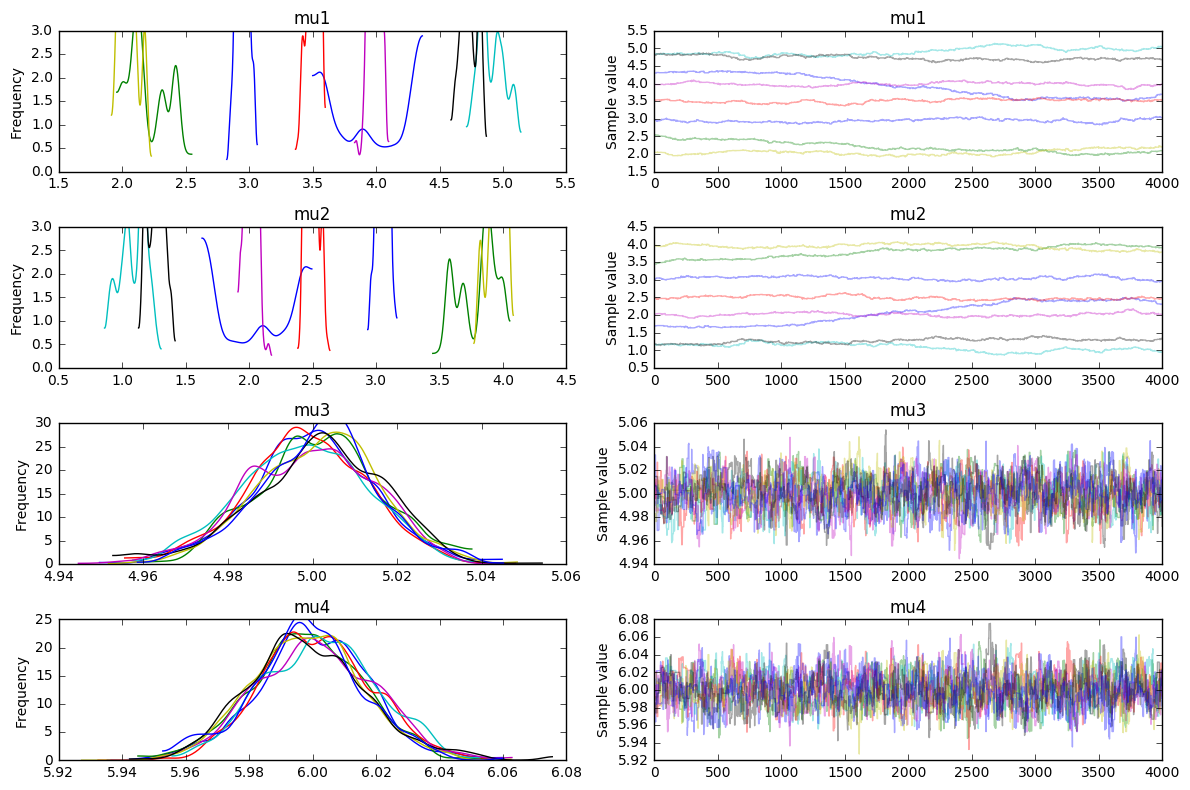

In [3]:
with basic_model:
    trace = pm.sample(5000, model=basic_model, step=pm.Metropolis(), njobs = 8)
    _ = pm.traceplot(trace[1000:])

We see something that we might expect. It is able to understand that `w3=5` and `w4=6` but it is uncertain about `w1` and `w2`. It certainly seems like there is a correlation between `w1` and `w2` though if you look at the traces (you should notice that the distribution plot for `w1` is the same as `w2` but mirrored from the center). 

It becomes even more obvious if we turn the trace plot into a corner plot. 

In [4]:
def trace_to_npdata(trace, model, start = 1000):
    var_names = sorted([_ for _ in model.named_vars.keys() if 'mu' in _])
    data = np.array([trace[start:].get_values(_, combine=True) for _ in var_names])
    data = data.T
    return var_names, data

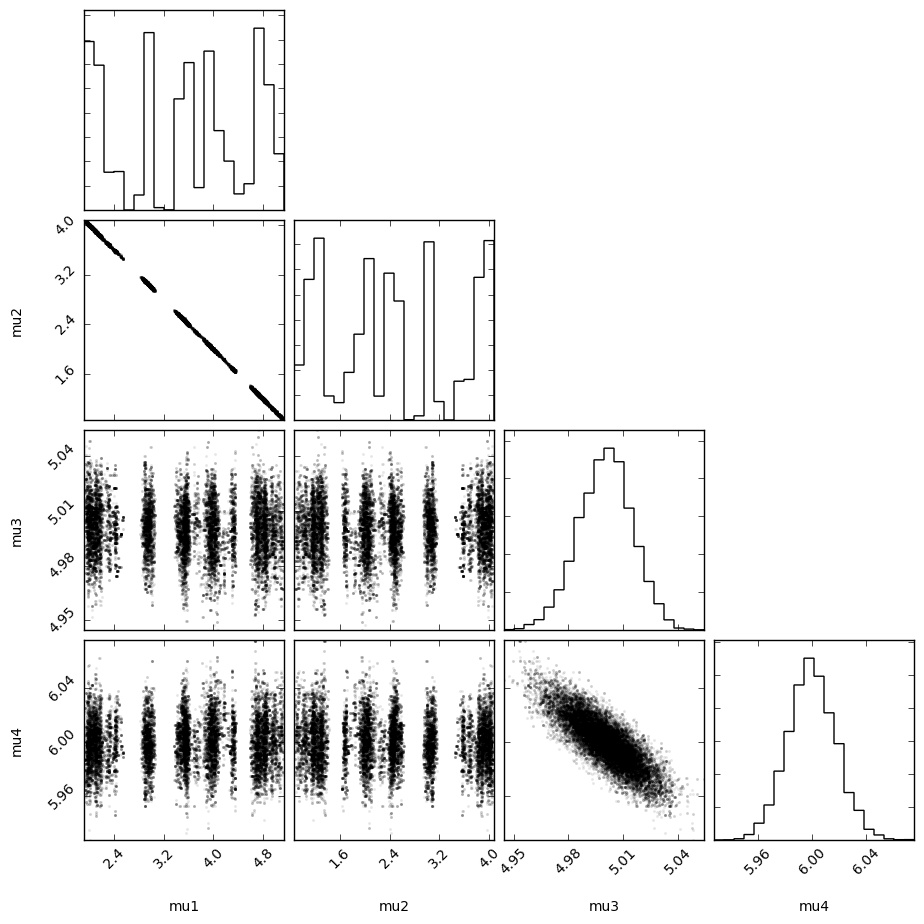

In [5]:
var_names, data = trace_to_npdata(trace, basic_model)

_ = corner.corner(data, 
                  fill_contours=False, 
                  plot_contours = False, 
                  plot_density = False,
                  labels = var_names)

Definately a correlation. 

### Maybe Even Try that VI 

If we feel like trying out the latest and greatest we could also attempt to approximate the distribution via variational inference. The results are a bit different, but seem workable enough. The parameters that were multi-peaker before are just the initial priors now.

In [6]:
with basic_model:
    v_params = pm.variational.advi(n=50000)
    trace = pm.variational.sample_vp(v_params, draws=50000)

Average ELBO = -12.448: 100%|██████████| 50000/50000 [00:02<00:00, 16861.06it/s]
Finished [100%]: Average ELBO = -12.413
100%|██████████| 50000/50000 [00:04<00:00, 10843.31it/s]


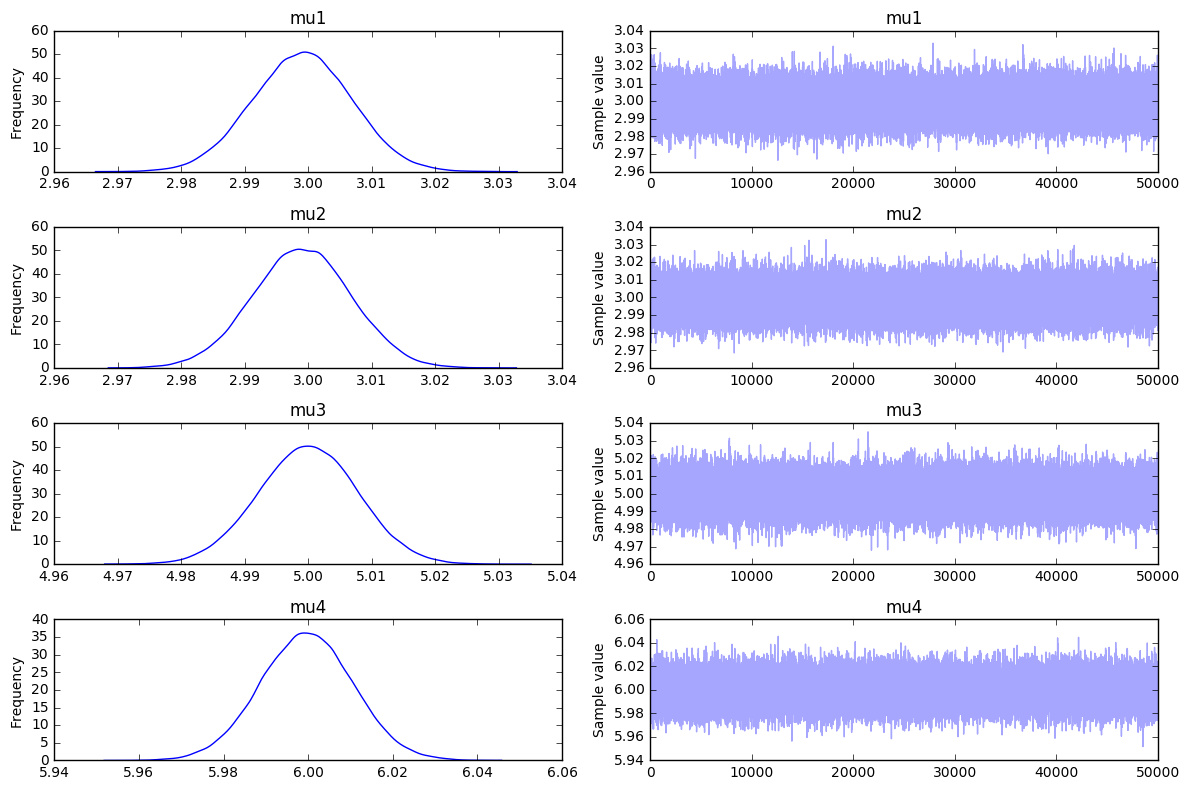

In [7]:
_ = pm.traceplot(trace)

# Now for a Bigger Model

The model we've just ran is a good place to start but it is not something we'd like to use in the kaggle. It may be more interested to see what happends if we play around with the number of known sums and the number of unknown weights. 

In [8]:
from functools import reduce
from operator import add
import random

In [9]:
random.seed(42)

num_variables = 10 
num_sums = 6
num_var_in_sums = 6

with pm.Model() as set_model:
    variables = []
    # declaring unknowns: note that I'm now modelling the priors as uniforms
    for i in range(num_variables):
        rand_val = random.randint(1, 15)
        var_name = 'mu_{}'.format(i)
        variables.append([pm.Uniform(var_name, lower=1, upper=15), rand_val])
        print("{}={}".format(variables[i][0], variables[i][1]))

    sums = [] 
    # declarig sums 
    for j in range(num_sums):
        random.shuffle(variables)
        s = sum([_[1] for _ in variables[:num_var_in_sums]])
        rv = pm.Normal(name = 's{}'.format(j), 
                       mu = reduce(add, [_[0] for _ in variables[:num_var_in_sums]]), 
                       sd = 0.2, observed = s)
        print("+".join([_[0].name for _ in variables[:num_var_in_sums]]) + "=" + str(s))
        sums.append(rv)
        
    for i, _ in enumerate(variables):
        variables[i][0].name = variables[i][0].name + '=' + str(variables[i][1])

mu_0=11
mu_1=2
mu_2=1
mu_3=12
mu_4=5
mu_5=4
mu_6=4
mu_7=3
mu_8=12
mu_9=2
mu_3+mu_2+mu_4+mu_9+mu_5+mu_7=27
mu_6+mu_7+mu_3+mu_4+mu_5+mu_8=40
mu_0+mu_9+mu_4+mu_6+mu_3+mu_1=36
mu_2+mu_7+mu_5+mu_6+mu_0+mu_4=28
mu_1+mu_2+mu_6+mu_5+mu_8+mu_4=28
mu_4+mu_0+mu_8+mu_3+mu_7+mu_6=47


Let's throw this into the sampler and see what we can learn.

100%|██████████| 10000/10000 [02:26<00:00, 68.46it/s]


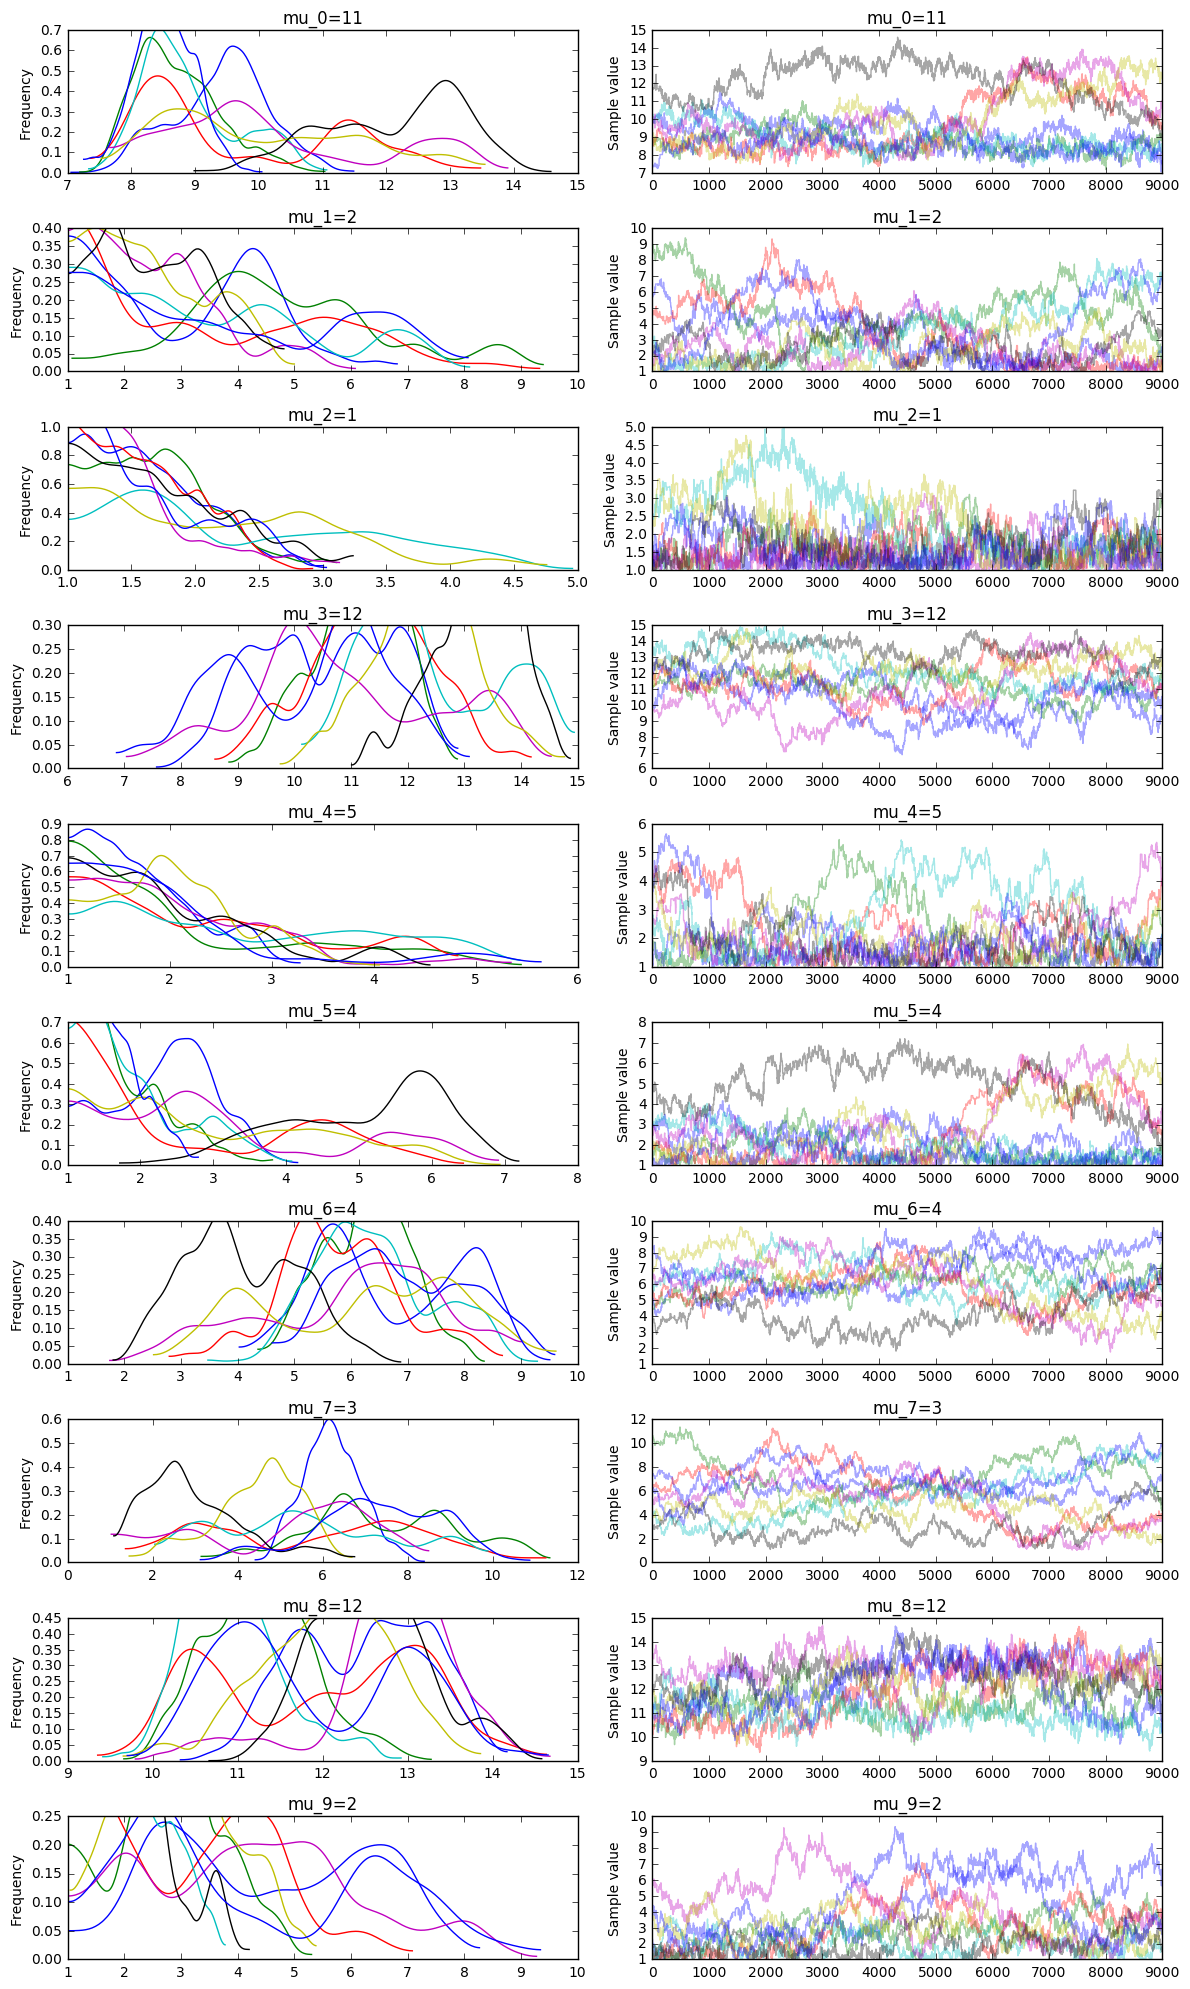

In [10]:
with set_model:
    trace = pm.sample(10000, init=None, step=pm.Metropolis(), njobs = 8)
    _ = pm.traceplot(trace[1000:])

You may appreciate the shape of the posterior more when you consider the corner plot. 

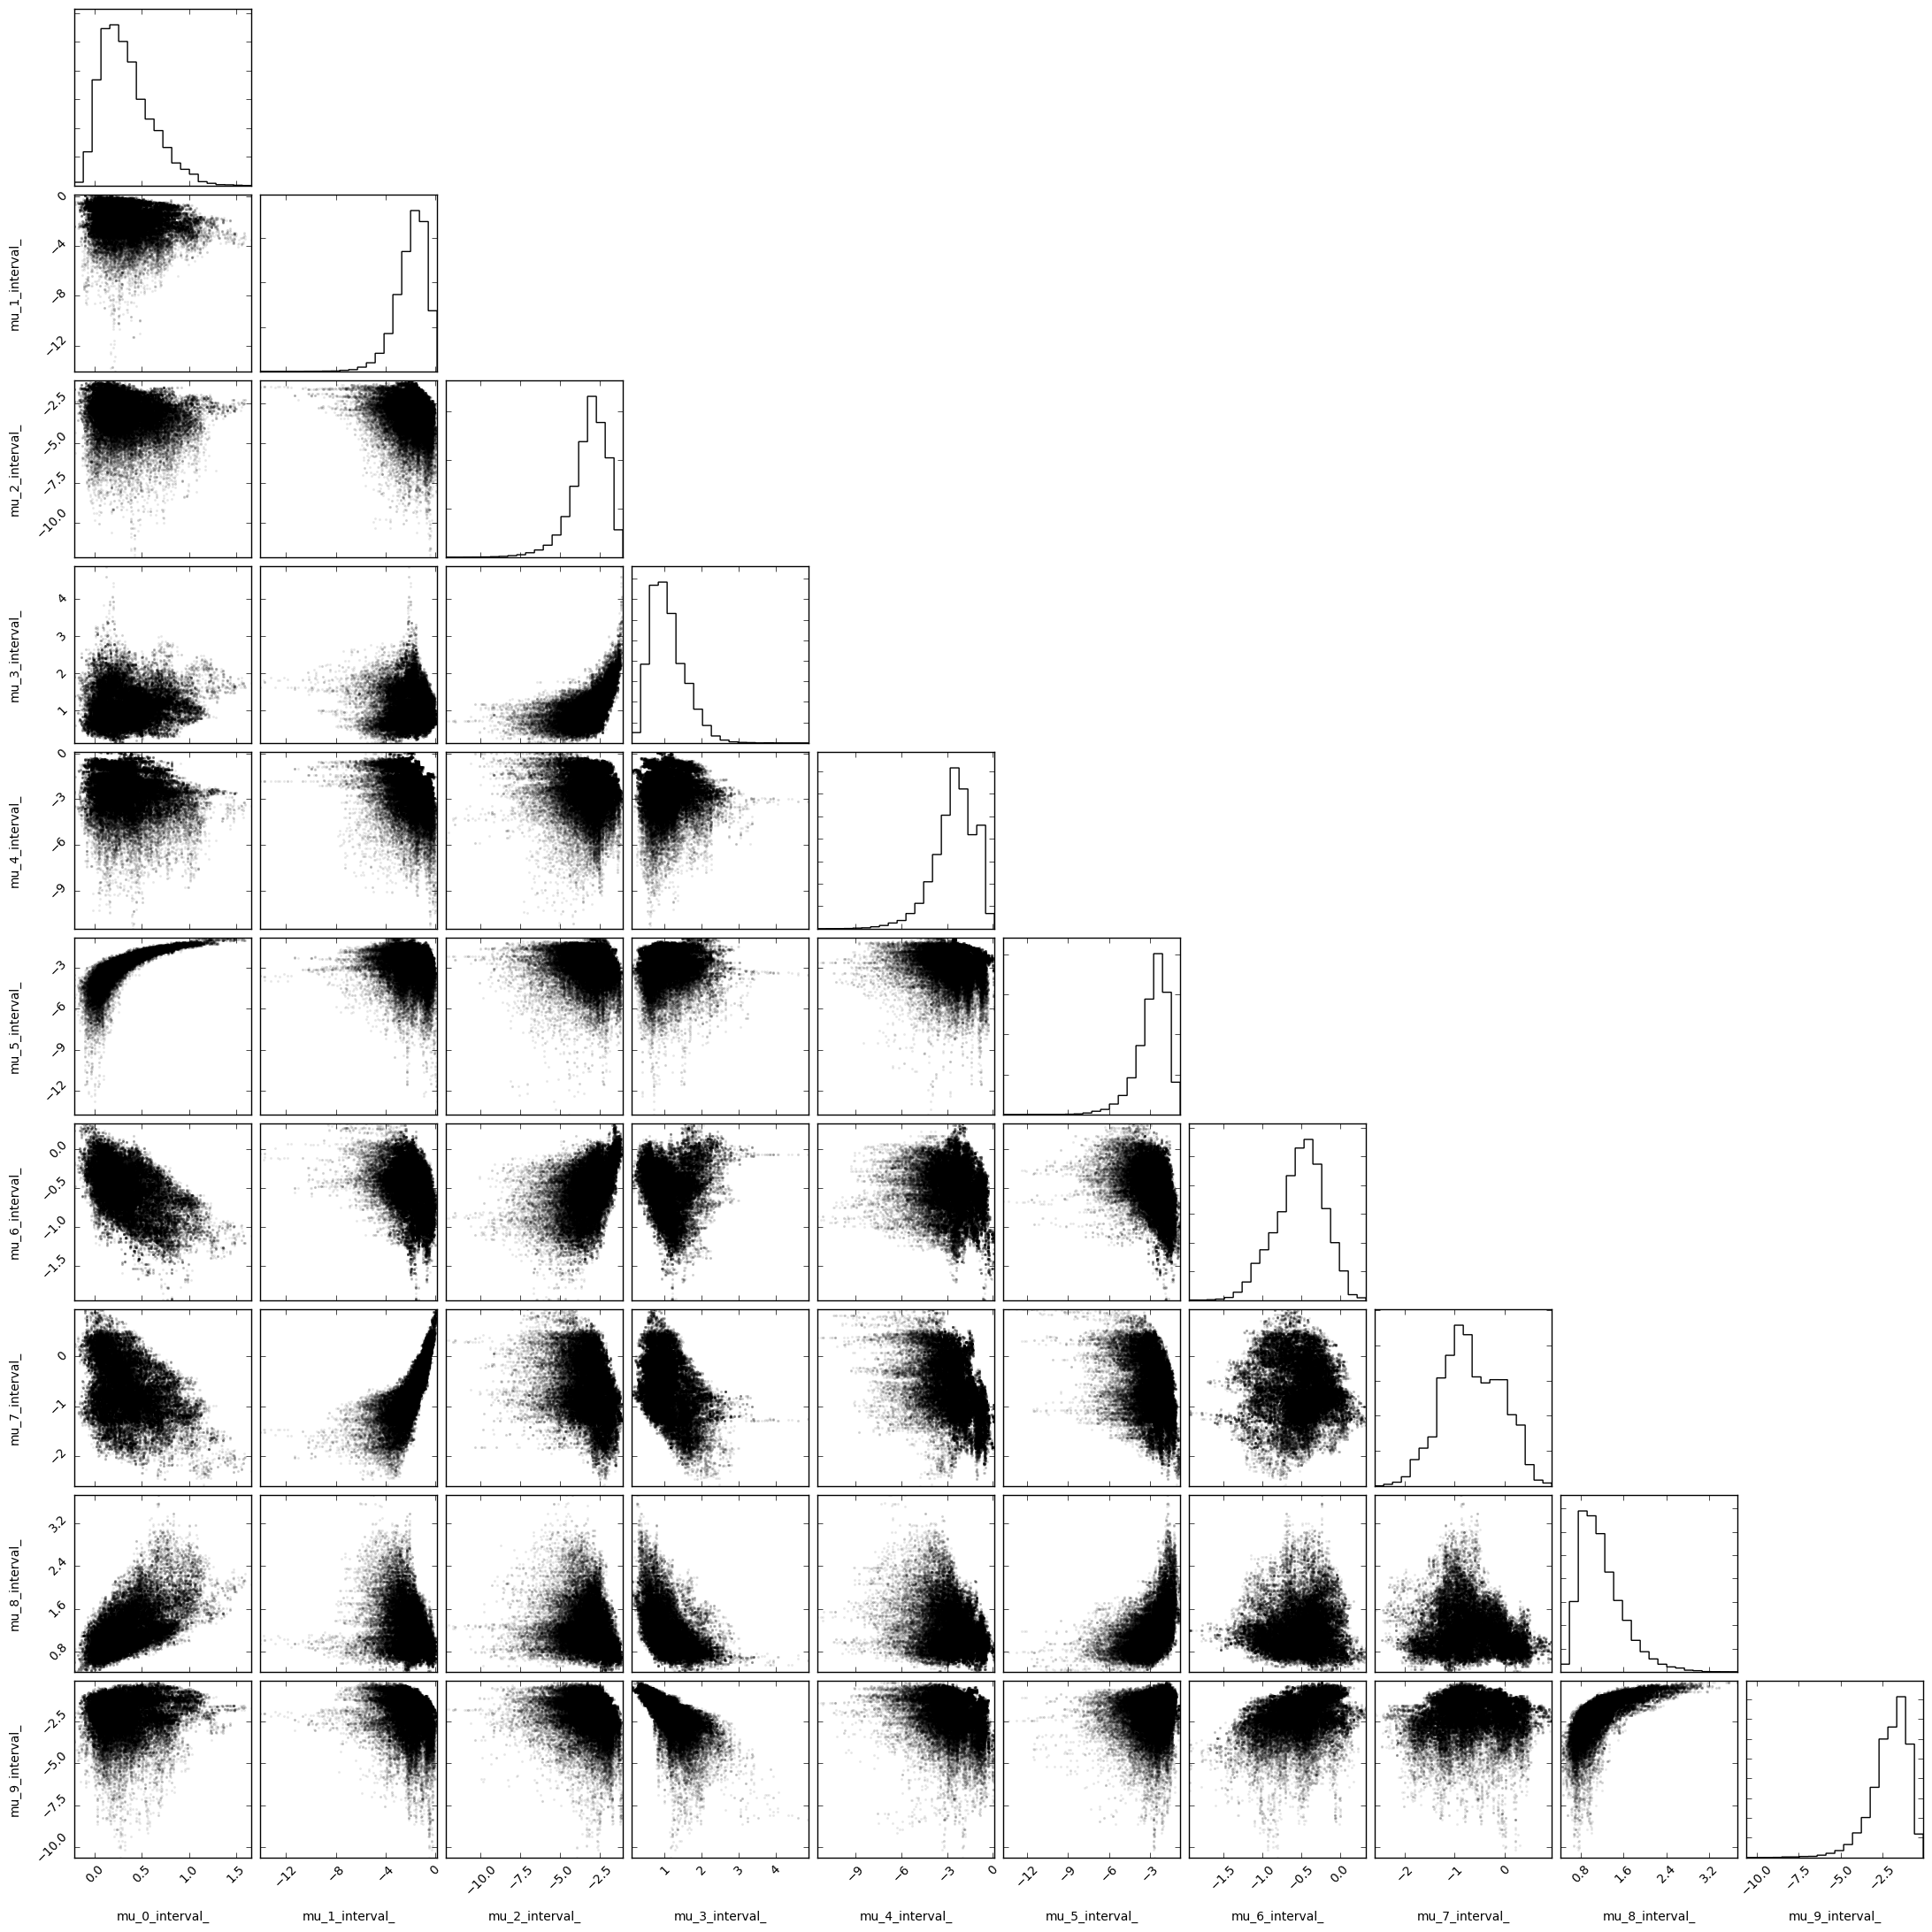

In [28]:
var_names, data = trace_to_npdata(trace, set_model)

_ = corner.corner(data, 
                  fill_contours=False, 
                  plot_contours = False, 
                  plot_density = False,
                  labels = var_names)

Let's also compare the results for variational inference. 

Average ELBO = -35.523: 100%|██████████| 50000/50000 [00:08<00:00, 6161.96it/s]
Finished [100%]: Average ELBO = -35.5
100%|██████████| 50000/50000 [00:11<00:00, 4538.16it/s]


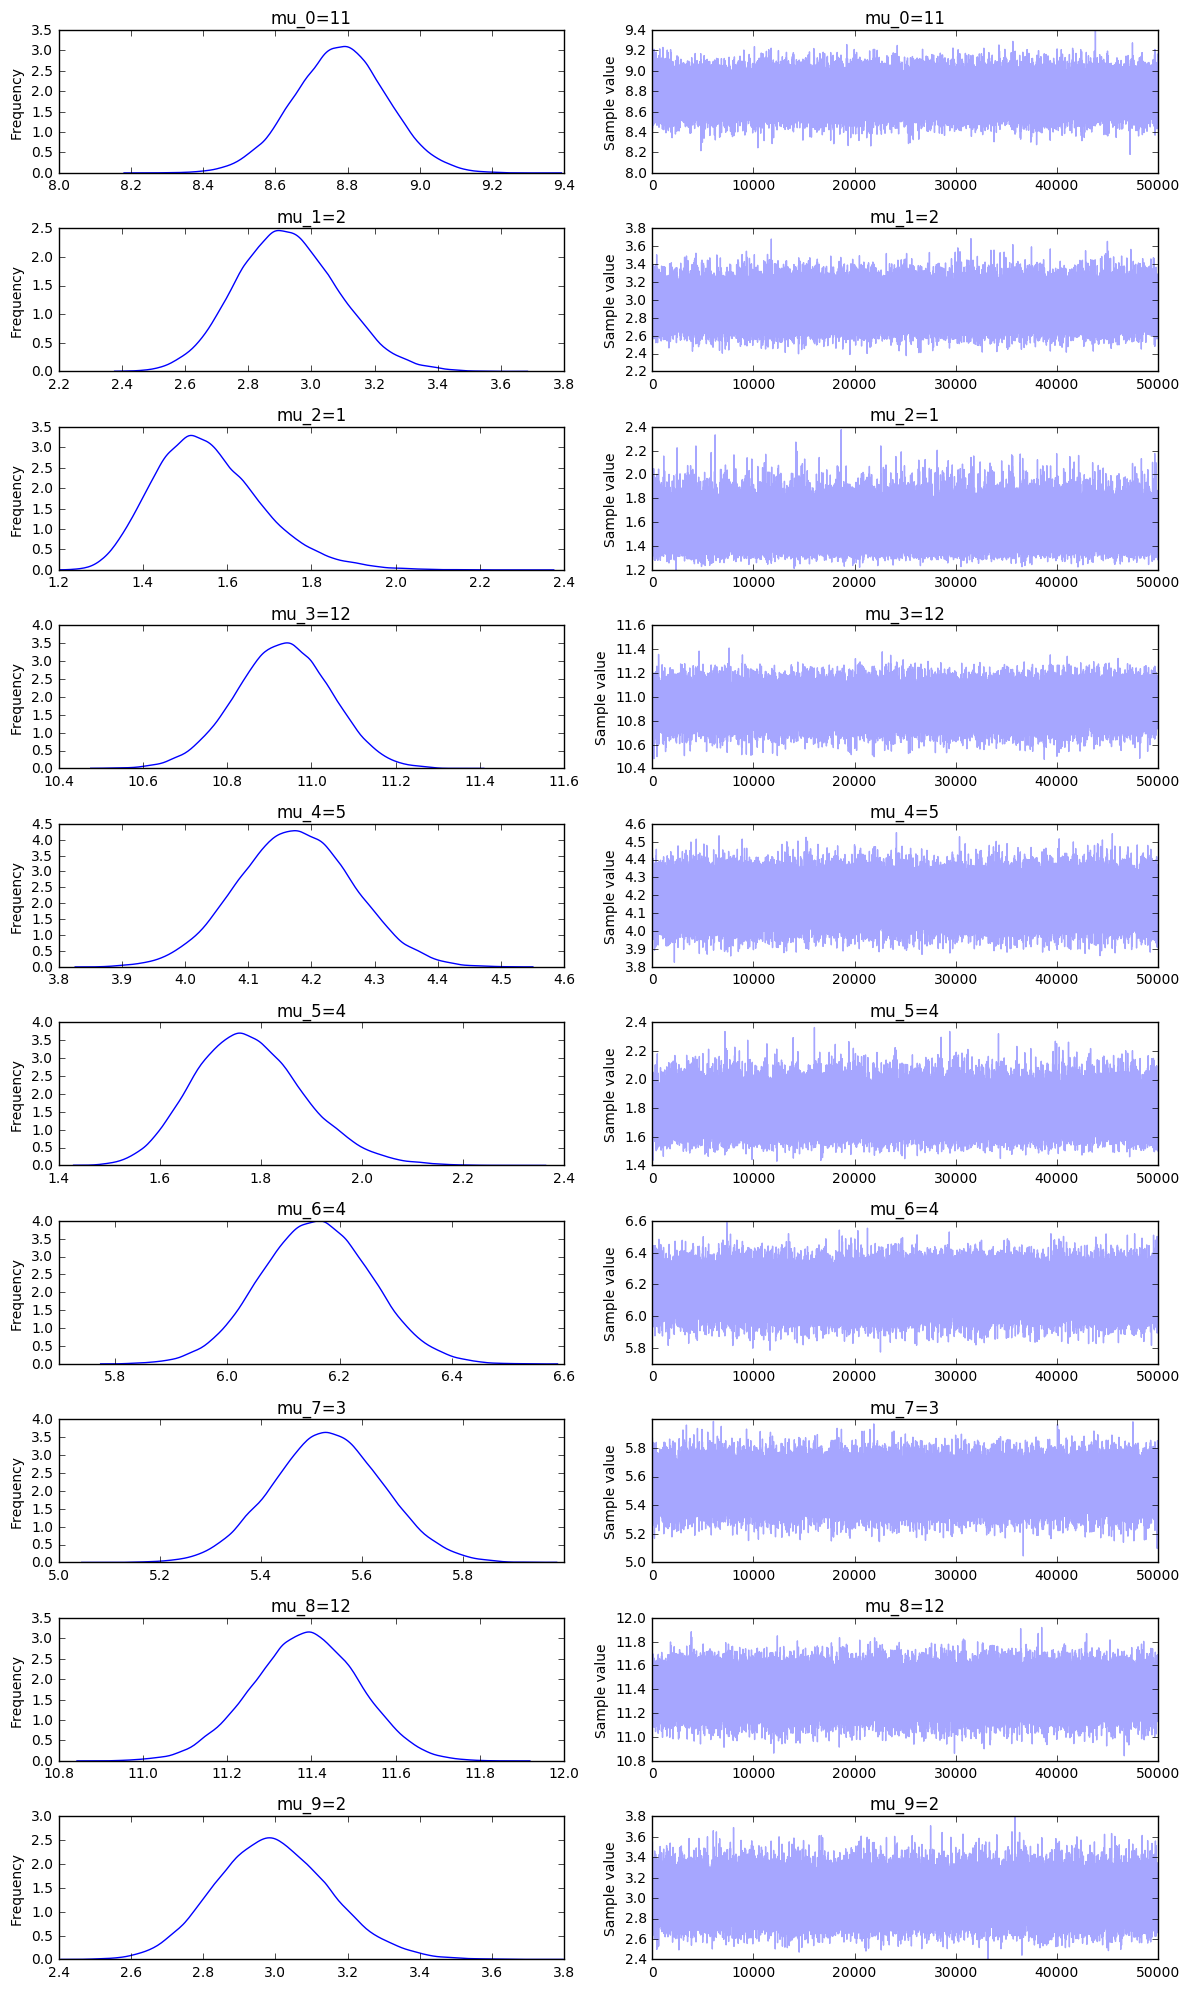

In [31]:
with set_model:
    v_params = pm.variational.advi(n=50000)
    trace = pm.variational.sample_vp(v_params, draws=50000)
    _ = pm.traceplot(trace)

# Conclusion 

Both variational inference and sampling work better if there are less unknown weights or more knowns sums of weights. It seems that variational inference is a whole lot faster but won't be able to recognize multi-peaked posteriors in the standard implementation of it. For this problem it seems that VI gives more bias where MCMC gives more variance. I'd use MCMC for this problem because it seems more reliable in the sense that the true variable seems to occur in the 99% likely region. 

Inference is a useful concept I hope this example might make the idea behind it a bit more tangible. MCMC gives us a very flexible method of modelling it and VI might help with the speed if we need it. 

I hope this document also makes it very clear that the general problem of deriving a posterior distribution is a hard one despite having these tools available. If you want to play around with this notebook, you can find it here.